# Neural Network

This notebook implements a minimal feedforward neural network (2 inputs → 1 hidden layer → 1 output) for binary classification using the Wisconsin Diagnostic Breast Cancer dataset. We'll cover:

- Data loading and selection of two features for visualization
- Weight and bias initialization
- Layer computations with selectable activation (Sigmoid/ReLU/Tanh)
- Mean Squared Error (MSE) loss
- Backpropagation and gradient descent updates
- Training for 500–1000 iterations with loss plot
- Testing on held-out data and decision boundary visualization


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path(r"c:\\Users\\axell\\Downloads\\breast+cancer+wisconsin+diagnostic\\CSC173-Neural-Network-Breast-Cancer")
DATA_FILE = DATA_DIR / "wdbc.data"

np.random.seed(42)



## Load data and select two features

- We'll parse the raw CSV (no header), assign column names, and convert labels `M`→1, `B`→0.
- We'll select two features for 2D visualization; default: `mean radius` and `mean texture`.
- We'll standardize features using training split statistics only.


In [ ]:
cols = [
    "id",
    "diagnosis",
    "mean radius","mean texture","mean perimeter","mean area","mean smoothness",
    "mean compactness","mean concavity","mean concave points","mean symmetry","mean fractal dimension",
    "radius se","texture se","perimeter se","area se","smoothness se",
    "compactness se","concavity se","concave points se","symmetry se","fractal dimension se",
    "worst radius","worst texture","worst perimeter","worst area","worst smoothness",
    "worst compactness","worst concavity","worst concave points","worst symmetry","worst fractal dimension"
]

df = pd.read_csv(DATA_FILE, header=None, names=cols)

label_map = {"M": 1, "B": 0}
df["label"] = df["diagnosis"].map(label_map)

feature_x = "mean radius"
feature_y = "mean texture"
X = df[[feature_x, feature_y]].to_numpy(dtype=float)
y = df["label"].to_numpy(dtype=float).reshape(-1, 1)

num_samples = X.shape[0]
perm = np.random.permutation(num_samples)
split = int(0.8 * num_samples)
train_idx, test_idx = perm[:split], perm[split:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Standardize using train stats
mean = X_train.mean(axis=0, keepdims=True)
std = X_train.std(axis=0, keepdims=True) + 1e-8
X_train_std = (X_train - mean) / std
X_test_std = (X_test - mean) / std

X_train_std.shape, X_test_std.shape, y_train.shape, y_test.shape


((455, 2), (114, 2), (455, 1), (114, 1))

## Network architecture and initialization

- Input: 2 features
- Hidden: choose width `H` in [2, 4]; activation: Sigmoid/ReLU/Tanh
- Output: 1 neuron

We initialize weights with small random values and biases to zeros. For ReLU/Tanh, slightly larger variance can help; we'll use He/Xavier-style scalings accordingly.


In [32]:
# Activations and derivatives

def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-z))

def dsigmoid(a: np.ndarray) -> np.ndarray:
    return a * (1.0 - a)

def relu(z: np.ndarray) -> np.ndarray:
    return np.maximum(0.0, z)

def drelu(z: np.ndarray) -> np.ndarray:
    return (z > 0).astype(z.dtype)

def tanh(z: np.ndarray) -> np.ndarray:
    return np.tanh(z)

def dtanh(a: np.ndarray) -> np.ndarray:
    return 1.0 - a**2

class TwoLayerNN:
    def __init__(self, input_dim: int = 2, hidden_dim: int = 3, activation: str = "tanh"):
        assert activation in {"sigmoid", "relu", "tanh"}
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.activation_name = activation
        
        # initialization (He for ReLU, Xavier for tanh/sigmoid)
        if activation == "relu":
            w1_scale = np.sqrt(2.0 / input_dim)
            w2_scale = np.sqrt(2.0 / hidden_dim)
        else:
            w1_scale = np.sqrt(1.0 / input_dim)
            w2_scale = np.sqrt(1.0 / hidden_dim)
        
        self.W1 = np.random.randn(input_dim, hidden_dim) * w1_scale
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, 1) * w2_scale
        self.b2 = np.zeros((1, 1))
    
    def _act(self, z: np.ndarray):
        if self.activation_name == "sigmoid":
            a = sigmoid(z)
            return a, dsigmoid(a)
        if self.activation_name == "relu":
            a = relu(z)
            return a, drelu(z)
        if self.activation_name == "tanh":
            a = tanh(z)
            return a, dtanh(a)
        raise ValueError("Unknown activation")
    
    def forward(self, X: np.ndarray):
        # Layer 1
        z1 = X @ self.W1 + self.b1
        a1, act1_prime = self._act(z1)
        # Output layer (linear -> sigmoid for binary output)
        z2 = a1 @ self.W2 + self.b2
        y_hat = sigmoid(z2)
        cache = {"X": X, "z1": z1, "a1": a1, "act1_prime": act1_prime, "z2": z2, "y_hat": y_hat}
        return y_hat, cache
    
    @staticmethod
    def mse_loss(y_hat: np.ndarray, y_true: np.ndarray) -> float:
        # Mean Squared Error
        return float(np.mean((y_hat - y_true) ** 2))


## Backpropagation and gradient descent

We compute gradients of MSE with respect to all parameters and update using learning rate `lr`.

- dL/dy_hat = 2*(y_hat - y)/N
- Output: y_hat = sigmoid(z2), so dL/dz2 = dL/dy_hat * sigmoid'(z2)
- Hidden: a1 = act(z1). Backpropagate via `W2` and activation derivative.

We'll implement a `train` method that runs multiple iterations and records loss.


In [33]:
def compute_grads_and_update(model: TwoLayerNN, cache: dict, y_true: np.ndarray, lr: float):
    N = y_true.shape[0]
    a1 = cache["a1"]
    z2 = cache["z2"]
    y_hat = cache["y_hat"]
    X = cache["X"]
    act1_prime = cache["act1_prime"]

    dL_dyhat = 2.0 * (y_hat - y_true) / N
    dz2 = dL_dyhat * dsigmoid(y_hat)


    dW2 = a1.T @ dz2
    db2 = np.sum(dz2, axis=0, keepdims=True)

    da1 = dz2 @ model.W2.T
    dz1 = da1 * act1_prime

    dW1 = X.T @ dz1
    db1 = np.sum(dz1, axis=0, keepdims=True)

    # Update
    model.W2 -= lr * dW2
    model.b2 -= lr * db2
    model.W1 -= lr * dW1
    model.b1 -= lr * db1

class Trainer:
    @staticmethod
    def train(model: TwoLayerNN, X: np.ndarray, y: np.ndarray, lr: float = 0.1, iters: int = 800):
        losses = []
        for i in range(iters):
            y_hat, cache = model.forward(X)
            loss = model.mse_loss(y_hat, y)
            losses.append(loss)
            compute_grads_and_update(model, cache, y, lr)
        return np.array(losses)

    @staticmethod
    def predict_proba(model: TwoLayerNN, X: np.ndarray) -> np.ndarray:
        y_hat, _ = model.forward(X)
        return y_hat

    @staticmethod
    def predict(model: TwoLayerNN, X: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        return (Trainer.predict_proba(model, X) >= threshold).astype(int)

    @staticmethod
    def accuracy(model: TwoLayerNN, X: np.ndarray, y_true: np.ndarray) -> float:
        y_pred = Trainer.predict(model, X)
        return float(np.mean(y_pred == y_true))


Training sigmoid model...
Training relu model...
Training tanh model...


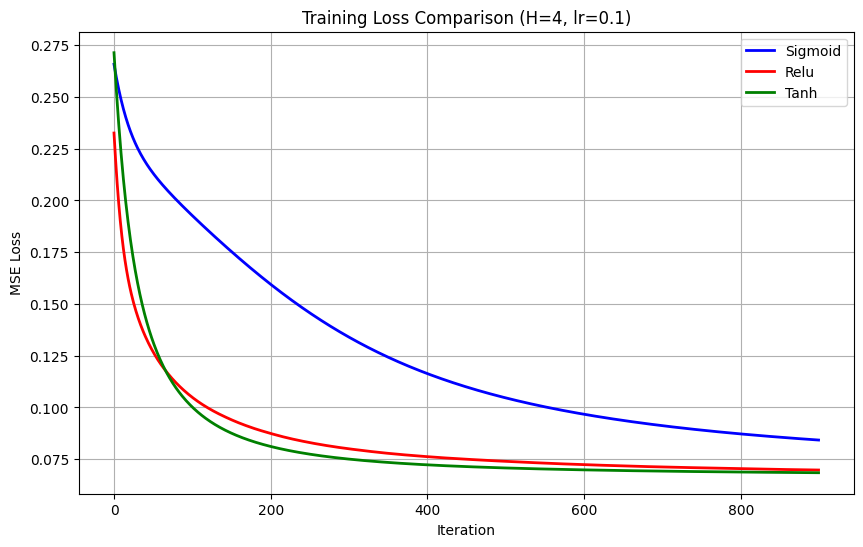

In [34]:
H = 4         
activations = ["sigmoid", "relu", "tanh"]
lr = 0.1
iters = 900

models = {}
losses_dict = {}
for activation in activations:
    print(f"Training {activation} model...")
    model = TwoLayerNN(input_dim=2, hidden_dim=H, activation=activation)
    losses = Trainer.train(model, X_train_std, y_train, lr=lr, iters=iters)
    models[activation] = model
    losses_dict[activation] = losses

plt.figure(figsize=(10,6))
colors = ['blue', 'red', 'green']
for i, (activation, losses) in enumerate(losses_dict.items()):
    plt.plot(losses, label=f'{activation.capitalize()}', color=colors[i], linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title(f"Training Loss Comparison (H={H}, lr={lr})")
plt.legend()
plt.grid(True)
plt.show()


In [35]:
# Evaluate accuracy for all models
import pandas as pd

results = []
for activation in activations:
    model = models[activation]
    train_acc = Trainer.accuracy(model, X_train_std, y_train)
    test_acc = Trainer.accuracy(model, X_test_std, y_test)
    results.append({
        'Activation': activation.capitalize(),
        'Train Accuracy': f"{train_acc:.3f}",
        'Test Accuracy': f"{test_acc:.3f}",
        'Overfitting': f"{train_acc - test_acc:.3f}"
    })

# Display results table
results_df = pd.DataFrame(results)
print("Model Performance Comparison:")
print("=" * 50)
print(results_df.to_string(index=False))
print("=" * 50)


Model Performance Comparison:
Activation Train Accuracy Test Accuracy Overfitting
   Sigmoid          0.903         0.816       0.088
      Relu          0.912         0.860       0.052
      Tanh          0.910         0.851       0.059


## Decision boundary and testing on new points

We'll visualize the learned decision boundary in standardized feature space and overlay the training data. We'll also test a few synthetic points.


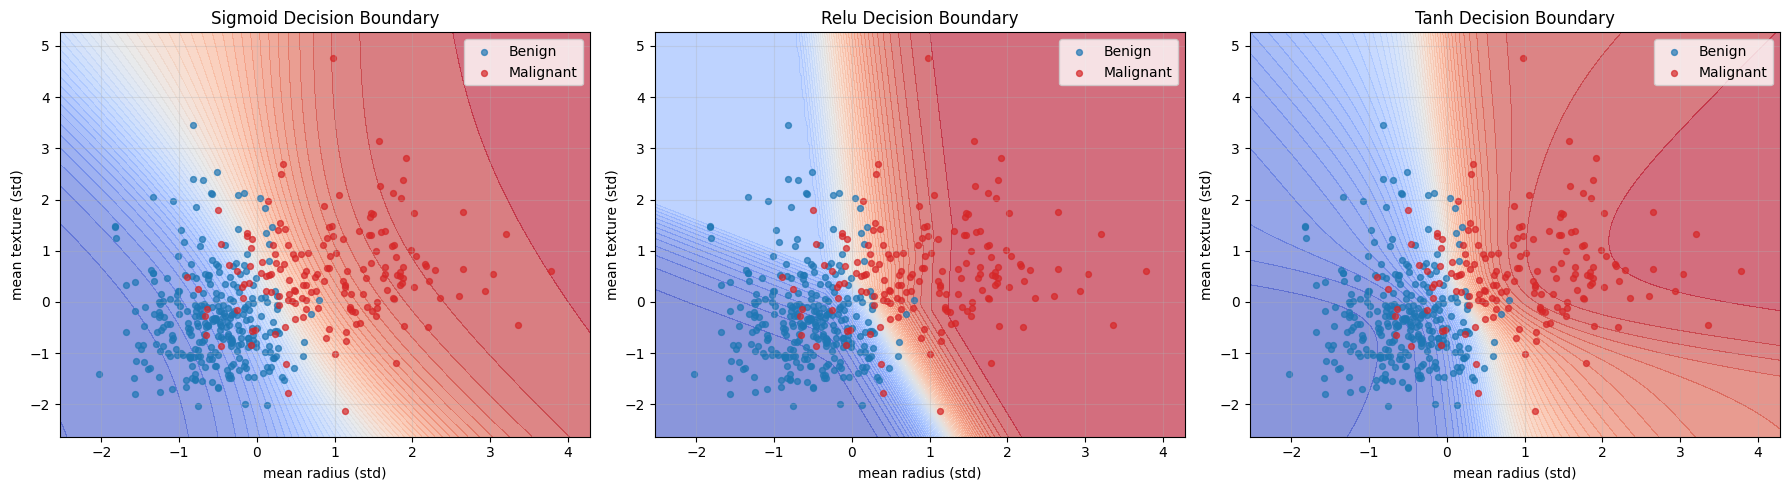


Predictions on test points:

Sigmoid Model:
  Point [0. 0.]: prob=0.347, pred=0
  Point [1. 1.]: prob=0.836, pred=1
  Point [-1. -1.]: prob=0.069, pred=0
  Point [ 2.  -0.5]: prob=0.869, pred=1

Relu Model:
  Point [0. 0.]: prob=0.299, pred=0
  Point [1. 1.]: prob=0.953, pred=1
  Point [-1. -1.]: prob=0.011, pred=0
  Point [ 2.  -0.5]: prob=0.998, pred=1

Tanh Model:
  Point [0. 0.]: prob=0.281, pred=0
  Point [1. 1.]: prob=0.958, pred=1
  Point [-1. -1.]: prob=0.018, pred=0
  Point [ 2.  -0.5]: prob=0.940, pred=1


In [36]:
x_min, x_max = X_train_std[:,0].min()-0.5, X_train_std[:,0].max()+0.5
y_min, y_max = X_train_std[:,1].min()-0.5, X_train_std[:,1].max()+0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['blue', 'red', 'green']

for i, (activation, model) in enumerate(models.items()):
    ax = axes[i]
    
    probs = Trainer.predict_proba(model, grid).reshape(xx.shape)
    
    cs = ax.contourf(xx, yy, probs, levels=50, cmap="coolwarm", alpha=0.6)
    
    ax.scatter(X_train_std[y_train[:,0]==0,0], X_train_std[y_train[:,0]==0,1], 
               s=18, c="tab:blue", label="Benign", alpha=0.7)
    ax.scatter(X_train_std[y_train[:,0]==1,0], X_train_std[y_train[:,0]==1,1], 
               s=18, c="tab:red", label="Malignant", alpha=0.7)
    
    ax.set_title(f"{activation.capitalize()} Decision Boundary")
    ax.set_xlabel(feature_x + " (std)")
    ax.set_ylabel(feature_y + " (std)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nPredictions on test points:")
print("=" * 60)
new_points = np.array([
    [0.0, 0.0],
    [1.0, 1.0],
    [-1.0, -1.0],
    [2.0, -0.5],
])

for activation, model in models.items():
    print(f"\n{activation.capitalize()} Model:")
    new_probs = Trainer.predict_proba(model, new_points)
    new_preds = (new_probs >= 0.5).astype(int)
    for p, pr, cl in zip(new_points, new_probs.flatten(), new_preds.flatten()):
        print(f"  Point {p}: prob={pr:.3f}, pred={int(cl)}")


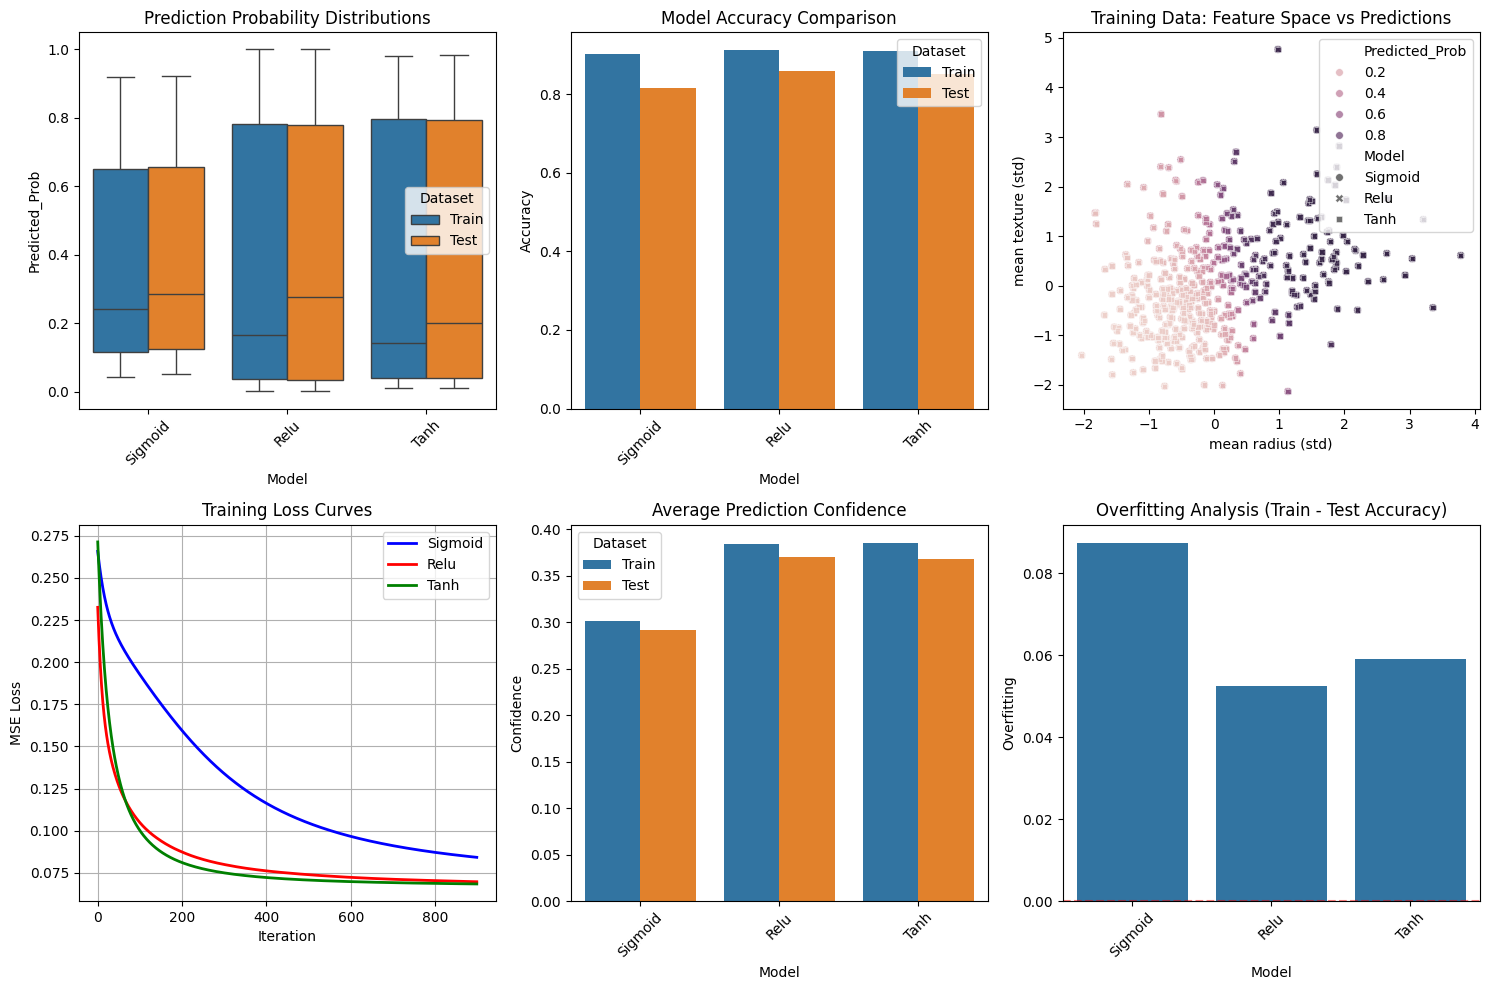


COMPREHENSIVE MODEL COMPARISON SUMMARY

Detailed Performance Metrics:
Activation Train_Acc Test_Acc Overfitting Train_Conf Test_Conf
   Sigmoid     0.903    0.816       0.088      0.302     0.292
      Relu     0.912    0.860       0.052      0.384     0.370
      Tanh     0.910    0.851       0.059      0.386     0.368



In [37]:
import seaborn as sns

comparison_data = []

for activation, model in models.items():
    train_probs = Trainer.predict_proba(model, X_train_std).flatten()
    test_probs = Trainer.predict_proba(model, X_test_std).flatten()
    
    # Training data
    for i in range(len(X_train_std)):
        comparison_data.append({
            'Feature_1': X_train_std[i, 0],
            'Feature_2': X_train_std[i, 1],
            'True_Label': y_train[i, 0],
            'Predicted_Prob': train_probs[i],
            'Model': activation.capitalize(),
            'Dataset': 'Train'
        })
    
    # Test data
    for i in range(len(X_test_std)):
        comparison_data.append({
            'Feature_1': X_test_std[i, 0],
            'Feature_2': X_test_std[i, 1],
            'True_Label': y_test[i, 0],
            'Predicted_Prob': test_probs[i],
            'Model': activation.capitalize(),
            'Dataset': 'Test'
        })

comparison_df = pd.DataFrame(comparison_data)

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
sns.boxplot(data=comparison_df, x='Model', y='Predicted_Prob', hue='Dataset')
plt.title('Prediction Probability Distributions')
plt.xticks(rotation=45)

# 2. Accuracy by model and dataset
plt.subplot(2, 3, 2)
accuracy_data = []
for activation in activations:
    model = models[activation]
    train_acc = Trainer.accuracy(model, X_train_std, y_train)
    test_acc = Trainer.accuracy(model, X_test_std, y_test)
    accuracy_data.extend([
        {'Model': activation.capitalize(), 'Accuracy': train_acc, 'Dataset': 'Train'},
        {'Model': activation.capitalize(), 'Accuracy': test_acc, 'Dataset': 'Test'}
    ])
accuracy_df = pd.DataFrame(accuracy_data)
sns.barplot(data=accuracy_df, x='Model', y='Accuracy', hue='Dataset')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)

# 3. Feature space colored by predictions
plt.subplot(2, 3, 3)
sns.scatterplot(data=comparison_df[comparison_df['Dataset']=='Train'], 
                x='Feature_1', y='Feature_2', 
                hue='Predicted_Prob', style='Model', 
                alpha=0.7, s=30)
plt.title('Training Data: Feature Space vs Predictions')
plt.xlabel(feature_x + ' (std)')
plt.ylabel(feature_y + ' (std)')

# 4. Loss curves comparison (already shown above, but add here for completeness)
plt.subplot(2, 3, 4)
colors = ['blue', 'red', 'green']
for i, (activation, losses) in enumerate(losses_dict.items()):
    plt.plot(losses, label=f'{activation.capitalize()}', color=colors[i], linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.grid(True)

# 5. Prediction confidence by model
plt.subplot(2, 3, 5)
confidence_data = []
for activation in activations:
    model = models[activation]
    train_probs = Trainer.predict_proba(model, X_train_std).flatten()
    test_probs = Trainer.predict_proba(model, X_test_std).flatten()
    
    # Calculate confidence (distance from 0.5)
    train_conf = np.abs(train_probs - 0.5)
    test_conf = np.abs(test_probs - 0.5)
    
    confidence_data.extend([
        {'Model': activation.capitalize(), 'Confidence': np.mean(train_conf), 'Dataset': 'Train'},
        {'Model': activation.capitalize(), 'Confidence': np.mean(test_conf), 'Dataset': 'Test'}
    ])
conf_df = pd.DataFrame(confidence_data)
sns.barplot(data=conf_df, x='Model', y='Confidence', hue='Dataset')
plt.title('Average Prediction Confidence')
plt.xticks(rotation=45)

# 6. Overfitting analysis
plt.subplot(2, 3, 6)
overfitting_data = []
for activation in activations:
    model = models[activation]
    train_acc = Trainer.accuracy(model, X_train_std, y_train)
    test_acc = Trainer.accuracy(model, X_test_std, y_test)
    overfitting_data.append({
        'Model': activation.capitalize(),
        'Overfitting': train_acc - test_acc
    })
overfitting_df = pd.DataFrame(overfitting_data)
sns.barplot(data=overfitting_df, x='Model', y='Overfitting')
plt.title('Overfitting Analysis (Train - Test Accuracy)')
plt.xticks(rotation=45)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON SUMMARY")
print("="*80)

final_results = []
for activation in activations:
    model = models[activation]
    train_acc = Trainer.accuracy(model, X_train_std, y_train)
    test_acc = Trainer.accuracy(model, X_test_std, y_test)
    
    train_probs = Trainer.predict_proba(model, X_train_std).flatten()
    test_probs = Trainer.predict_proba(model, X_test_std).flatten()
    
    train_conf = np.mean(np.abs(train_probs - 0.5))
    test_conf = np.mean(np.abs(test_probs - 0.5))
    
    final_results.append({
        'Activation': activation.capitalize(),
        'Train_Acc': f"{train_acc:.3f}",
        'Test_Acc': f"{test_acc:.3f}",
        'Overfitting': f"{train_acc - test_acc:.3f}",
        'Train_Conf': f"{train_conf:.3f}",
        'Test_Conf': f"{test_conf:.3f}"
    })

final_df = pd.DataFrame(final_results)
print("\nDetailed Performance Metrics:")
print(final_df.to_string(index=False))
print("\n" + "="*80)
